In [2]:

#%%
import os
import sys
import json
from argparse import ArgumentParser
import yaml
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
# personal files
os.chdir('/mnt/work/')
sys.path.append(os.path.join(os.path.dirname(__file__), '..', '..'))
import models
from datasets import MelDataset, vctkDataset

# root path
os.chdir('/mnt/work/')

# ------------------------------------------------------------------------
# config loading
data_config_path = "./Animal/configs/vctk/dataset_vctk.yaml"

# model path
model_config_path = "./Animal/configs/vctk/model_vctk.yaml"
model_path = './Animal/output/vctk'
exp_name = 'VAEbase-vctk_1-c_100.0_1.3-i_10.0_60.0'
checkpoint = "80000.pth.tar"

# device
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# ------------------------------------------------------------------------

# dataset vctk
dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
analy_set = vctkDataset(dataset_config, subset='test')

analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)


# model loading
model_config = yaml.load(open(model_config_path, "r"), Loader=yaml.FullLoader)
model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
model = model_type(model_config, device).to(device) # model config load

#load model
save_path = os.path.join(model_path, exp_name, 'checkpoint', checkpoint)
ckpt = torch.load(save_path)
model.load_state_dict(ckpt["model"])
model.eval()

# data store
total_z_indi_mu = []
total_z_indi_log_std = []
total_z_indi = []

total_z_con_mu = []
total_z_con_log_std = []
total_z_con = []

total_x_gt = [] # mel
total_x_rec = [] # reconstuct mel
total_ctID = []
total_cID = []

for mel, lenx, indi_mel, cID_file, cID in tqdm(analy_loader):
        mel = mel.to(device)
        lenx = lenx.to(device)
        indi_mel = indi_mel.to(device)
        
        outputs = model(mel, lenx, indi_mel) 
        
        z_indi_mu = outputs['indi_mu'].detach().cpu().numpy()
        z_indi_log_std = outputs['indi_log_std'].detach().cpu().numpy()
        z_indi = outputs['z_indi'].detach().cpu().numpy() 
        
        z_con_mu = outputs['con_mu'].detach().cpu().numpy() 
        z_con_log_std = outputs['con_log_std'].detach().cpu().numpy() 
        z_con = outputs['z_con'].detach().cpu().numpy() 
        x_rec = outputs['x_rec'].detach().cpu().numpy() 
        
        total_z_indi_mu.append(z_indi_mu)
        total_z_indi_log_std.append(z_indi_log_std)
        total_z_indi.append(z_indi)
        total_z_con_mu.append(z_con_mu)
        total_z_con_log_std.append(z_con_log_std)
        total_z_con.append(z_con)
        
        total_x_gt.append(mel.detach().cpu().numpy())
        total_x_rec.append(x_rec)
        
        # print('cID',cID[0][1:])
        total_cID.append(int(cID[0][1:]))

    
unique_elements, counts = np.unique(total_cID, return_counts=True)
for element, count in zip(unique_elements, counts):
    print('cID_counts',f"{element}: {count}")
    


KeyError: 'dataset'

In [ ]:
used_label = total_ctID
unique_labels = np.unique(used_label)
unique_labels

In [ ]:
from sklearn.manifold import TSNE

# call type
total_z_con_1D = []
for i in total_z_con_mu: # total_z_con; content miu: total_z_con_mu; content var: total_z_con_log_std
    total_z_con_1D.append(i.sum(2))

# tsne
total_z_con_1D = np.array(total_z_con_1D).squeeze()
tsne = TSNE(n_components = 2, perplexity = 30, n_iter = 1000)

# print('total_z_con_1D',total_z_con_1D[0])

data_2d = tsne.fit_transform(total_z_con_1D) # cnontent


(8988, 2)
[[225 225 225 ...   5   5   5]]
[  5 225 226 227 228 229 230 231 232 233 234 236 237 238 239 240 241 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 292 293 294 295 297 298 299 300 301
 302 303 304 305 306 307 308 310 311 312 313 314 315 316 317 318 323 326
 329 330 333 334 335 336 339 340 341 343 345 347 351 360 361 362 363 364
 374 376]
[False False False ...  True  True  True]
[ True  True  True ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False

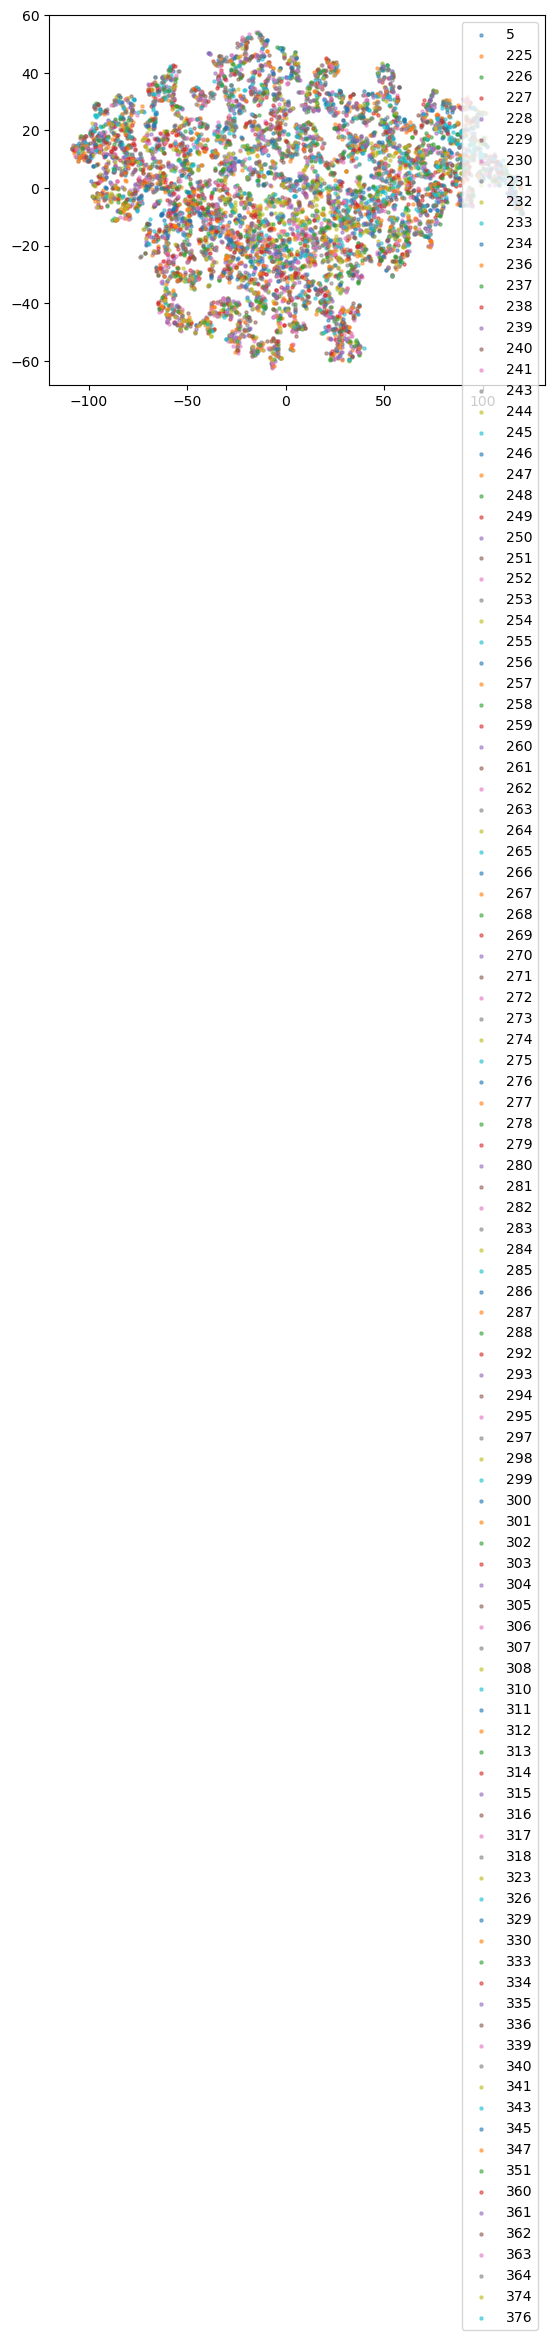

In [ ]:

# Get unique labels
total_cID = np.array(total_cID)
used_label = np.expand_dims(total_cID, axis=0)
unique_labels = np.unique(used_label)

print(data_2d.shape)
print(used_label)
print(unique_labels)

for label in unique_labels:
    # 这里我们不需要指定axis，因为used_label只有一行
    label_mask = np.all(used_label == label, axis=0)
    print(label_mask)
    # Select data for this label
    data_for_label = data_2d[label_mask]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=5)

# Add a legend
plt.legend()
plt.show()

In [ ]:
from sklearn.manifold import TSNE

# total_z_con = 
# caller
total_z_indi = np.array(total_z_indi).squeeze() # indi
total_z_indi_mu = np.array(total_z_indi_mu).squeeze() # individual miu
total_z_indi_log_std = np.array(total_z_indi_log_std).squeeze()
total_indi = np.hstack((total_z_indi_mu, total_z_indi_log_std))

# tsne
tsne = TSNE(n_components=2, perplexity = 30, n_iter = 1000)
data_2d_speaker = tsne.fit_transform(total_z_indi_mu)



(8988, 2)
[[225 225 225 ...   5   5   5]]
[  5 225 226 227 228 229 230 231 232 233 234 236 237 238 239 240 241 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 292 293 294 295 297 298 299 300 301
 302 303 304 305 306 307 308 310 311 312 313 314 315 316 317 318 323 326
 329 330 333 334 335 336 339 340 341 343 345 347 351 360 361 362 363 364
 374 376]
label 5
[False False False ...  True  True  True]
label 225
[ True  True  True ... False False False]
label 226
[False False False ... False False False]
label 227
[False False False ... False False False]
label 228
[False False False ... False False False]
label 229
[False False False ... False False False]
label 230
[False False False ... False False False]
label 231
[False False False ... False False False]
label 232
[False False False ... False False False]
label 233
[False False False ... False False

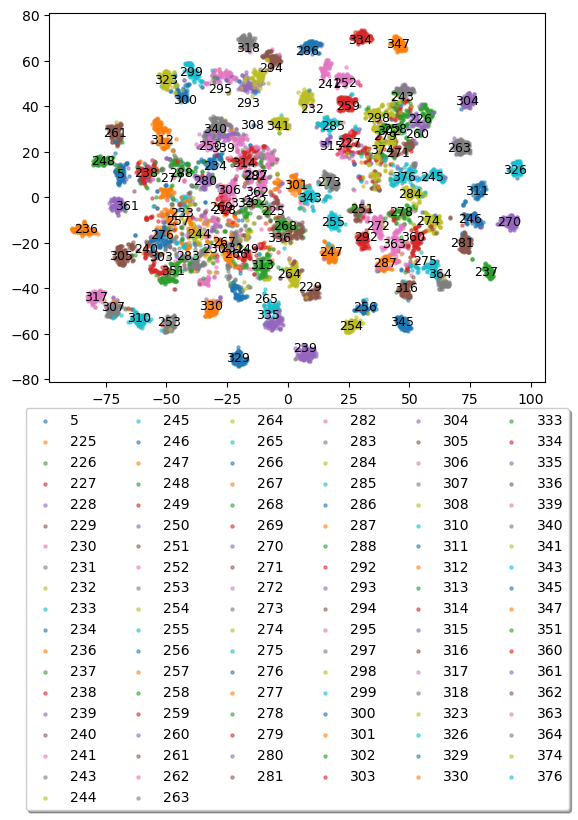

In [ ]:
# Get unique labels
total_cID = np.array(total_cID)
used_label = np.expand_dims(total_cID, axis=0)
unique_labels = np.unique(used_label)

print(data_2d.shape)
print(used_label)
print(unique_labels)

for label in unique_labels:
    # 这里我们不需要指定axis，因为used_label只有一行
    label_mask = np.all(used_label == label, axis=0)
     
    # print('label',label)
    # print(label_mask)
    # Select data for this label
    data_for_label = data_2d_speaker[label_mask]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=5)

    # 计算每个类别的中心点坐标
    centroid = np.mean(data_for_label, axis=0)
    # 在中心点上添加标签
    plt.text(centroid[0], centroid[1], str(label), fontsize=9, color='black', ha='center', va='center')

# Add a legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
plt.show()

In [6]:
# test vctk model on monkey dataset
import os
from tabnanny import check
import yaml
import torch
import argparse
import models
import numpy as np
from tqdm import tqdm
from collections import Counter
from datasets import MelDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

# root path
os.chdir('/mnt/work/')

# ------------------------------------------------------------------------
# config loading
data_config_path = "./Animal/configs/monkey/dataset2.yaml" 

# model path
# load vctk model
model_config_path = "./Animal/configs/vctk/model_vctk.yaml"
model_path = './Animal/output/vctk'
exp_name = 'VAEbase-vctk_1-c_100.0_1.3-i_10.0_60.0'
checkpoint = "80000.pth.tar"

# animal model
# model_config_path = "./Animal/configs/monkey/model1.yaml"
# model_path = './Animal/output/monkey'
# exp_name = 'VAEbase-512-8chunk-c_100.0_1.3-i_10.0_60.0'
# checkpoint = "100000.pth.tar"

# device
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# ------------------------------------------------------------------------

# dataset
dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
used_key = [[
              'calltype_1',
              'calltype_2',
              # 'calltype_3',
              # 'calltype_4',
              # 'calltype_5',
              # 'calltype_6',
              # 'calltype_7',
              # 'calltype_8',
              # 'calltype_9',
              # 'calltype_10'
                ],
                [
                'twin_1_0',
                'twin_1_1',
                'twin_2_2',
                'twin_2_3',
                'twin_3_4',
                'twin_3_5',
                # 'twin_4_6',
                # 'twin_4_7',
                # 'twin_5_8',
                # 'twin_5_9'
                  ]]
analy_set = MelDataset(dataset_config, used_key = used_key, subset='test')


analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)


# model loading
model_config = yaml.load(open(model_config_path, "r"), Loader=yaml.FullLoader)
model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
model = model_type(model_config, device).to(device) # model config load

#load model
save_path = os.path.join(model_path, exp_name, 'checkpoint', checkpoint)
ckpt = torch.load(save_path)
model.load_state_dict(ckpt["model"])
model.eval()

# data store
total_z_indi_mu = []
total_z_indi_log_std = []
total_z_indi = []

total_z_con_mu = []
total_z_con_log_std = []
total_z_con = []

total_x_gt = [] # mel
total_x_rec = [] # reconstuct mel
total_ctID = []
total_cID = []

for mel, lenx, indi_mel, ctID, cID in tqdm(analy_loader):
        mel = mel.to(device)
        lenx = lenx.to(device)
        indi_mel = indi_mel.to(device)
        
        outputs = model(mel, lenx, indi_mel) 
        
        z_indi_mu = outputs['indi_mu'].detach().cpu().numpy()
        z_indi_log_std = outputs['indi_log_std'].detach().cpu().numpy()
        z_indi = outputs['z_indi'].detach().cpu().numpy() 
        
        z_con_mu = outputs['con_mu'].detach().cpu().numpy() 
        z_con_log_std = outputs['con_log_std'].detach().cpu().numpy() 
        z_con = outputs['z_con'].detach().cpu().numpy() 
        x_rec = outputs['x_rec'].detach().cpu().numpy() 
        
        total_z_indi_mu.append(z_indi_mu)
        total_z_indi_log_std.append(z_indi_log_std)
        total_z_indi.append(z_indi)
        total_z_con_mu.append(z_con_mu)
        total_z_con_log_std.append(z_con_log_std)
        total_z_con.append(z_con)
        
        total_x_gt.append(mel.detach().cpu().numpy())
        total_x_rec.append(x_rec)
        total_ctID.append(ctID.detach().cpu().numpy())
        total_cID.append(cID.detach().cpu().numpy())

unique_elements, counts = np.unique(total_ctID, return_counts=True)
for element, count in zip(unique_elements, counts):
    print('ctID_counts',f"{element}: {count}")
    
unique_elements, counts = np.unique(total_cID, return_counts=True)
for element, count in zip(unique_elements, counts):
    print('cID_counts',f"{element}: {count}")
    

Dict_1 ['calltype_1', 'calltype_2']
Dict_2 ['twin_1_0', 'twin_1_1', 'twin_2_2', 'twin_2_3', 'twin_3_4', 'twin_3_5']


  0%|          | 0/6517 [00:00<?, ?it/s]

100%|██████████| 6517/6517 [01:05<00:00, 99.26it/s] 

ctID_counts 1: 3213
ctID_counts 2: 3304
cID_counts 0: 1870
cID_counts 1: 887
cID_counts 2: 1938
cID_counts 3: 663
cID_counts 4: 737
cID_counts 5: 422


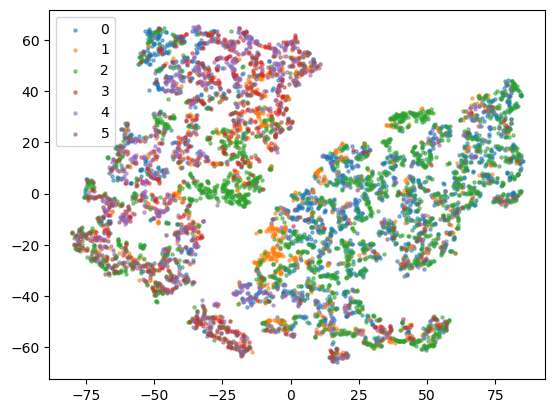

In [11]:

from sklearn.manifold import TSNE

# analyse the call type
# call type
total_z_con_1D = []
for i in total_z_con_mu: # total_z_con; content miu: total_z_con_mu; content var: total_z_con_log_std
    total_z_con_1D.append(i.sum(2))

# tsne
total_z_con_1D = np.array(total_z_con_1D).squeeze()
tsne = TSNE(n_components = 2, perplexity = 30, n_iter = 1000)

data_2d = tsne.fit_transform(total_z_con_1D) # cnontent

# Get unique labels
# used_label = total_ctID
used_label = total_cID

unique_labels = np.unique(used_label)

# Plot the transformed data with labels
for label in unique_labels:
    # Select data for this label
    data_for_label = data_2d[np.all(used_label == label, axis=1)]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=5)

# Add a legend
plt.legend()
plt.show()

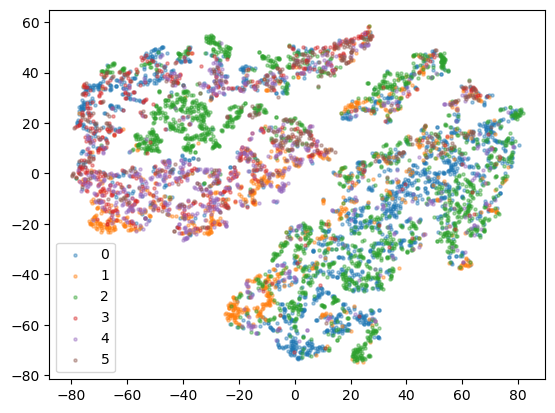

In [10]:
from sklearn.manifold import TSNE

# analyze different caller 
# caller
total_z_indi = np.array(total_z_indi).squeeze() # indi
total_z_indi_mu = np.array(total_z_indi_mu).squeeze() # individual miu
total_z_indi_log_std = np.array(total_z_indi_log_std).squeeze()
total_indi = np.hstack((total_z_indi_mu, total_z_indi_log_std))

# tsne
tsne = TSNE(n_components=2, perplexity = 30, n_iter = 1000)
data_2d_caller = tsne.fit_transform(total_z_indi_mu)

# Get unique labels
# used caller
# used_label = total_ctID
used_label = total_cID

unique_labels = np.unique(used_label)

# Plot the transformed data with labels
for label in unique_labels:
    # Select data for this label
    data_for_label = data_2d_caller[np.all(used_label == label, axis=1)]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.4, s=5)

# Add a legend
plt.legend()
plt.show()

In [2]:
#%%
import os
import sys
import json
from argparse import ArgumentParser
import yaml
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
import models
from datasets import MelDataset, vctkDataset

# root path
os.chdir('/mnt/work/')

# ------------------------------------------------------------------------
# config loading
data_config_path = "./Animal/configs/vctk/dataset_vctk.yaml"

# model path
model_config_path = "./Animal/configs/vctk/model_vctk.yaml"
model_path = './Animal/output/vctk'
exp_name = 'VAEbase-vctk_1-c_100.0_1.3-i_10.0_60.0'
checkpoint = "80000.pth.tar"

# device
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# model loading
model_config = yaml.load(open(model_config_path, "r"), Loader=yaml.FullLoader)
model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
model = model_type(model_config, device).to(device) # model config load

#load model
save_path = os.path.join(model_path, exp_name, 'checkpoint', checkpoint)
ckpt = torch.load(save_path)
model.load_state_dict(ckpt["model"])
model.eval()


# dataset vctk
dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
analy_set = vctkDataset(dataset_config, subset='test')

analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)


100%|██████████| 8988/8988 [01:18<00:00, 114.58it/s]


cID_type: p228_061


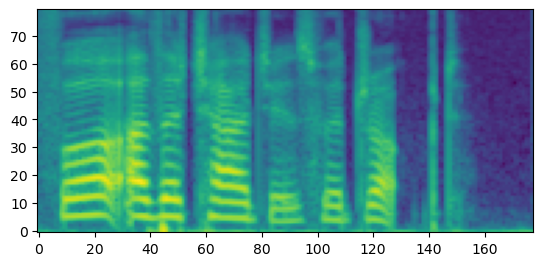

(1, 128)
reconstructed: p228_061


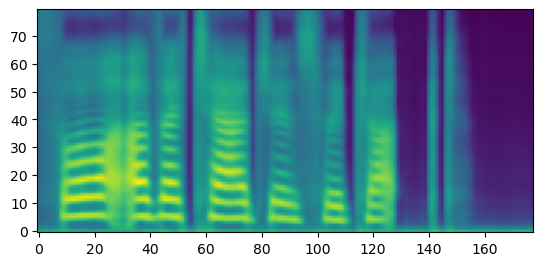

(1, 128)
-0.0145716015
[-3.0, -2.6, -2.2, -1.8000000000000003, -1.4000000000000004, -1.0000000000000004, -0.6000000000000005, -0.20000000000000062, 0.1999999999999993, 0.5999999999999992, 0.9999999999999991, 1.3999999999999986, 1.799999999999999, 2.1999999999999993, 2.5999999999999988]
z_sta -3.0
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


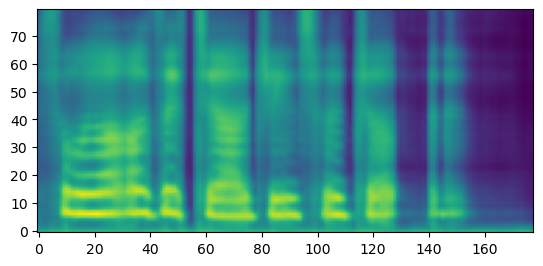

z_sta -2.6
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


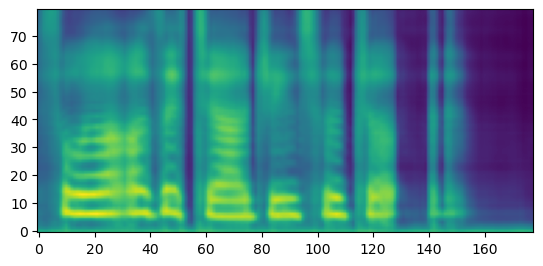

z_sta -2.2
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


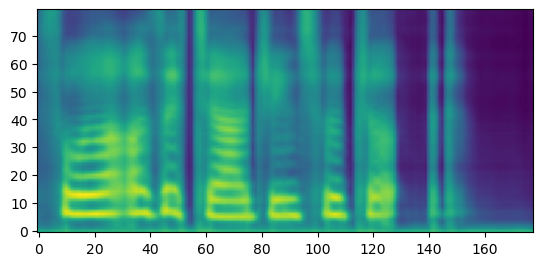

z_sta -1.8000000000000003
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


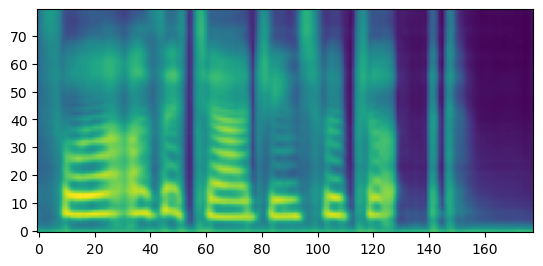

z_sta -1.4000000000000004
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


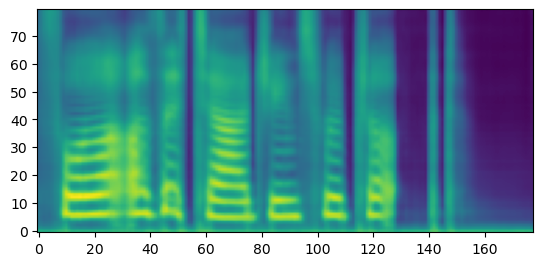

z_sta -1.0000000000000004
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


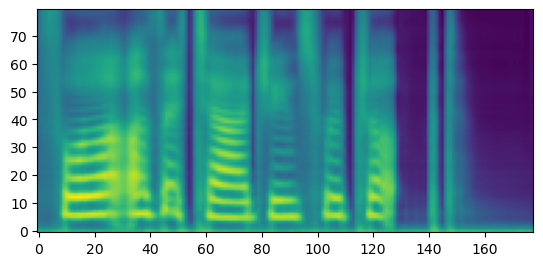

z_sta -0.6000000000000005
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


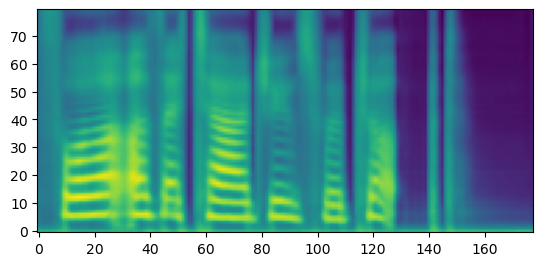

z_sta -0.20000000000000062
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


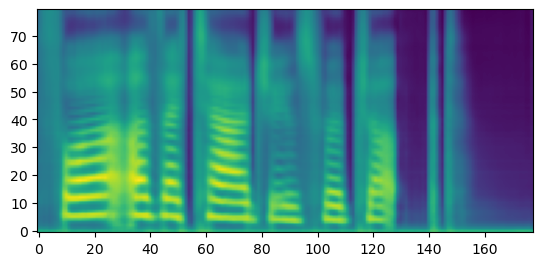

z_sta 0.1999999999999993
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


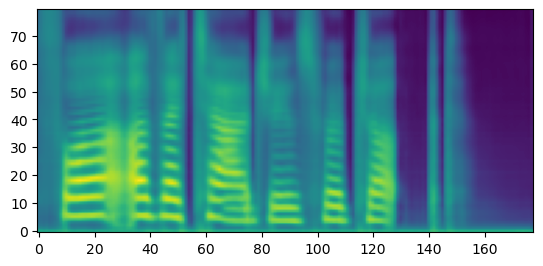

z_sta 0.5999999999999992
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


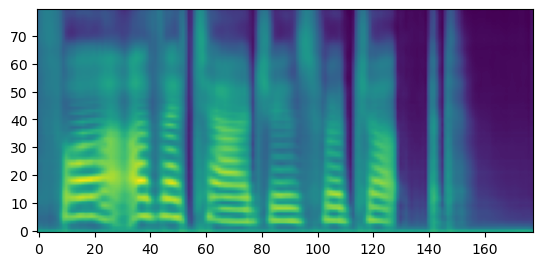

z_sta 0.9999999999999991
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


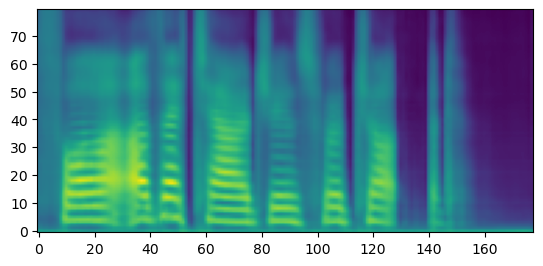

z_sta 1.3999999999999986
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


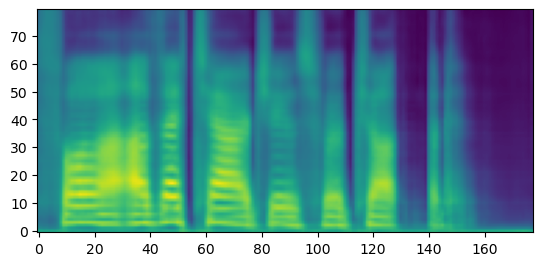

z_sta 1.799999999999999
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


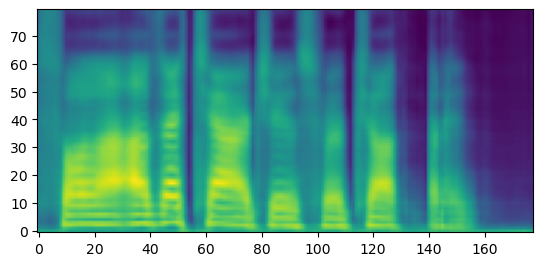

z_sta 2.1999999999999993
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


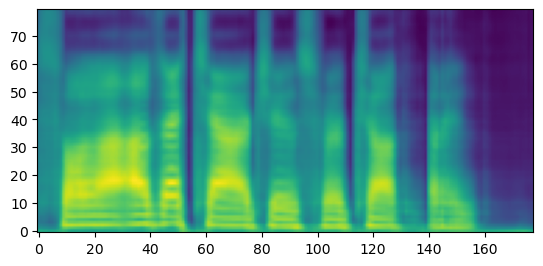

z_sta 2.5999999999999988
z_dy torch.Size([1, 128, 178]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 178]) torch.Size([1, 128])


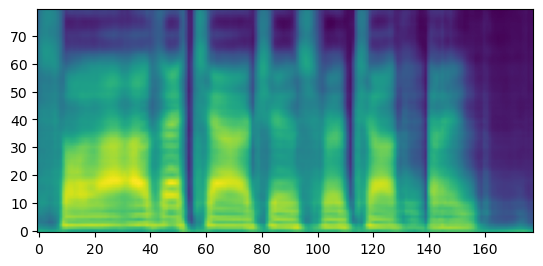

indi kl tensor(59.8783, device='cuda:1', grad_fn=<MeanBackward0>)
[93, 65, 88, 68, 109, 98, 63, 67, 73, 77, 82, 121, 28, 104, 10, 0, 37, 122, 86, 21, 101, 16, 13, 4, 111, 85, 91, 79, 1, 57, 51, 48, 46, 39, 119, 24, 61, 110, 75, 108, 50, 125, 105, 15, 18, 38, 92, 5, 29, 56, 103, 117, 32, 45, 23, 27, 70, 83, 74, 6, 64, 58, 30, 34, 112, 26, 102, 2, 120, 116, 90, 106, 127, 72, 96, 84, 17, 11, 40, 107, 97, 80, 20, 99, 78, 31, 7, 60, 66, 54, 59, 19, 118, 9, 47, 44, 114, 43, 42, 8, 62, 113, 87, 25, 81, 22, 36, 33, 69, 95, 53, 49, 126, 41, 76, 35, 89, 115, 124, 14, 3, 52, 55, 12, 123, 71, 94, 100]
sorted indi_mu [array([0.16026637], dtype=float32), array([-0.04304888], dtype=float32), array([-0.20000854], dtype=float32), array([-3.011479], dtype=float32), array([0.3710641], dtype=float32), array([-0.306266], dtype=float32), array([-0.24501634], dtype=float32), array([-0.27904323], dtype=float32), array([-0.05529128], dtype=float32), array([0.01348897], dtype=float32), array([-0.16075799], dtyp

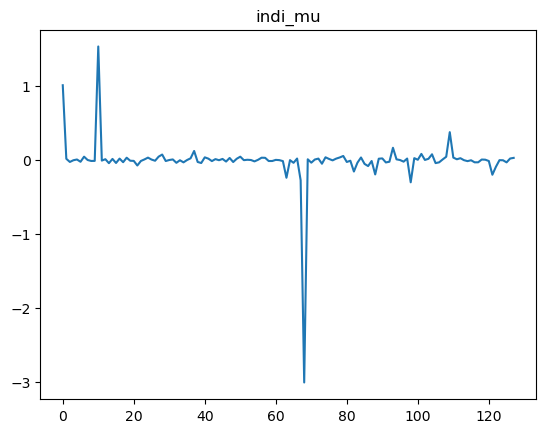

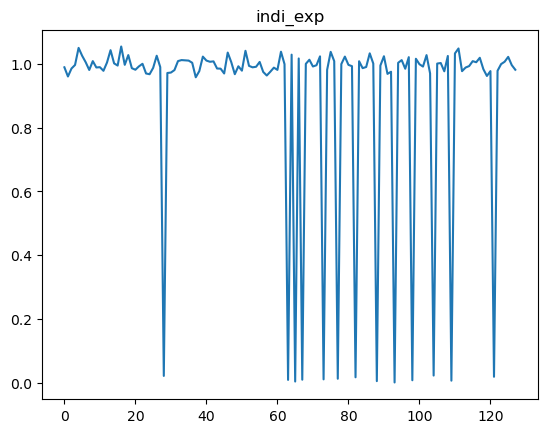

28 [0.06872055] [0.02237439] [3.3024502]
63 [-0.24501634] [0.00989428] [4.145864]
65 [-0.04304888] [0.00481694] [4.8365545]
67 [-0.27904323] [0.01053274] [4.092255]
73 [-0.05529128] [0.01158739] [3.9594338]
77 [0.01348897] [0.01349164] [3.805867]
82 [-0.16075799] [0.0180663] [3.526792]
88 [-0.20000854] [0.00603557] [4.6301045]
93 [0.16026637] [0.00181547] [5.8242564]
98 [-0.306266] [0.00877975] [4.2822456]
104 [0.0722675] [0.02350707] [3.2533417]
109 [0.3710641] [0.00753644] [4.4568777]
121 [-0.2041353] [0.0196605] [3.4501724]


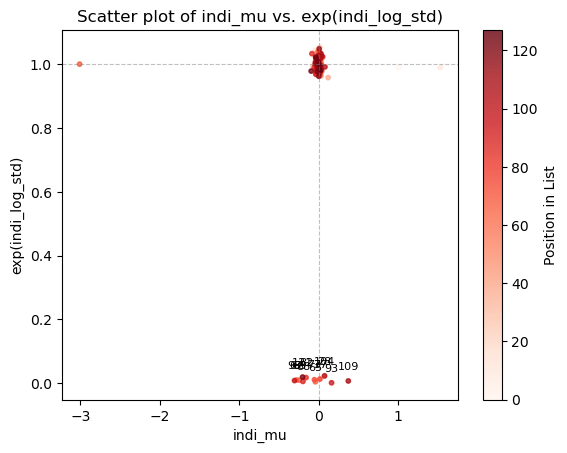

In [17]:
# input to model
from matplotlib.pyplot import ylim
import torch.distributions as D
from itertools import islice

mel, lenx, indi_mel, cID_file, cID = next(islice(analy_loader, 210, None))

# plot sepc
print('cID_type:',cID_file[0])
plt.imshow(mel[0], origin = 'lower')
plt.show()


# test input model
mel = mel.to(device)
lenx = lenx.to(device)
indi_mel = indi_mel.to(device)

#--------------------------------------------------------------------------------
# random input
# indi_mel = torch.normal(mean = 1, std = 1, size=(1, 80, 256)).to(device)

# output of trained model
outputs = model(mel, lenx, indi_mel) 
z_indi_mu = outputs['indi_mu'].detach().cpu().numpy()
z_indi_log_std = outputs['indi_log_std'].detach().cpu().numpy()
z_indi = outputs['z_indi'].detach().cpu().numpy() 
z_con_mu = outputs['con_mu'].detach().cpu().numpy() 
z_con_log_std = outputs['con_log_std'].detach().cpu().numpy() 
z_con = outputs['z_con'].detach().cpu().numpy() 
x_rec = outputs['x_rec'].detach().cpu().numpy() 

# plot recon
print(z_indi_mu.shape)
print('reconstructed:',cID_file[0])
plt.imshow(x_rec[0], origin = 'lower')
plt.show()

# miu & sigma
print(z_indi_mu.shape)
print(np.mean(z_indi_mu))
#--------------------------------------------------------------------------------
# step load encoders
dy_mu, dy_std= model.dynamicEncoder(mel, lenx)
sta_mu, sta_log_std = model.staticEncoder(indi_mel)

# sample
z_dy = model.dynamicEncoder.sample(dy_mu, dy_std)
z_sta = model.staticEncoder.sample(sta_mu, sta_log_std)

# 修改z value
# exp_name = 'VAEbase-vctk_1-c_100.0_1.3-i_10.0_60.0'
# checkpoint = "80000.pth.tar"
# [65]unit control 泛频

# z_sta = torch.zeros_like(z_sta)
value = [i for i in np.arange(-3, 3, 0.4)]
print(value)
for i in value:
    z_sta[:,65] = i 
    print('z_sta',i)
    print('z_dy',z_dy.shape,'z_sta',z_sta.shape)
    
    # z_sta = torch.zeros_like(z_sta)
    # z_dy = torch.zeros_like(z_dy)

    time_len = z_dy.size(2)
    z_sta_in = z_sta.unsqueeze(2).expand(-1, -1, time_len)

    dec_in = torch.cat([z_sta_in, z_dy], dim=1)
    x_rec = model.decoder(dec_in, lenx)

    print('shape',dy_mu.shape, sta_mu.shape)

    plt.imshow(x_rec[0].detach().cpu().numpy() , origin = 'lower')
    plt.show()
#--------------------------------------------------------------------------------
# indi KL
# formula
indi_kl = model.staticEncoder.kl_divergence(outputs['indi_mu'], outputs['indi_log_std'])
print('indi kl', indi_kl)
# step by step for KL
post = D.Normal(outputs['indi_mu'], torch.exp(outputs['indi_log_std']))
prior = D.Normal(
    torch.zeros_like(outputs['indi_mu'], requires_grad=False),
    torch.ones_like(torch.exp(outputs['indi_log_std']), requires_grad=False))
kl = D.kl.kl_divergence(post, prior)
#--------------------------------------------------------------------------------
# plot miu & sigma
kl = kl.detach().cpu().numpy().T
indi_mu = outputs['indi_mu'].detach().cpu().numpy().T
indi_exp = torch.exp(outputs['indi_log_std']).detach().cpu().numpy().T

#--------------------------------------------------------------------------------
# 排序miu std unit的kl散度值
# print(kl[0])
sorted_indices = sorted(range(len(kl)), key=lambda i: kl[i], reverse=True)
print(sorted_indices)
# print('sorted kl',[kl[i] for i in sorted_indices])
print('sorted indi_mu',[indi_mu[i] for i in sorted_indices])
print('sorted indi_exp',[indi_exp[i] for i in sorted_indices])

# print('kl value',kl)
print('kl shape', kl.shape)
print('kl mean',kl.mean())
print('kl sum',kl.sum())
# kl = torch.mean(torch.sum(kl, dim=1))

#--------------------------------------------------------------------------------
plt.plot(indi_mu)
plt.title('indi_mu')
plt.show()

plt.plot(indi_exp)
plt.title('indi_exp')
plt.show()
#--------------------------------------------------------------------------------
# scatter plot
indices = np.arange(indi_mu.shape[0])
plt.scatter(indi_mu, indi_exp, s=10, c=indices, cmap='Reds', alpha=0.8)
plt.colorbar(label='Position in List')
plt.axhline(1, color='grey', linestyle='--', alpha=0.5, linewidth=0.8)
plt.axvline(0, color='grey', linestyle='--', alpha=0.5, linewidth=0.8)

for i, (x, y) in enumerate(zip(indi_mu, indi_exp)):
    if y < 0.2:
        print(i,x,y,kl[i])
        plt.text(x, y + 0.03, f'{i}', fontsize=8, ha='center', va='bottom')


plt.title('Scatter plot of indi_mu vs. exp(indi_log_std)')
plt.xlabel('indi_mu')
plt.ylabel('exp(indi_log_std)')
plt.show()